# Chapter 8: Object Detection and Recognition

## Problems

1.  **Object Detection** with pretrained deep learning Models  
    1.1 with **MobileNet** (`caffe` model) using `opencv-python`      
    1.2 With **Yolo v3** using `gluoncv` and `mxnet`      
2.  **Custom Object Detection** with **Transfer learning** using **Yolo-V4**
3.  Selective Coloring with **Mask R-CNN**
4.  **Face Verification** with **DeepFace**
5.  **Barcode** and **QR code detection**

### Problem 1: Object Detection with pretrained deep learning Modelsision tasks. `torchvision` packages.

### 1.1: with MobileNet (`caffe` model) using `opencv-python`

In [ ]:
# import the necessary packages
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import cv2
from PIL import Image, ImageDraw, ImageFont

[INFO] loading model...


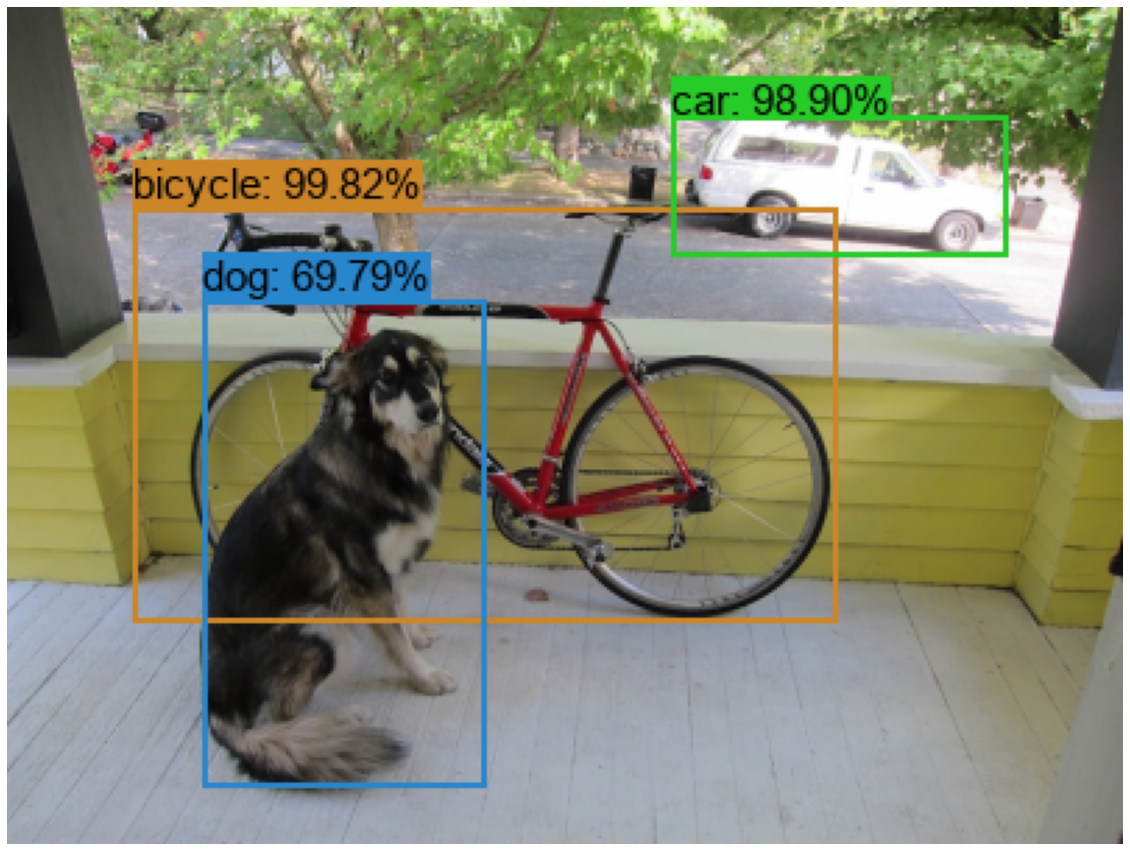

In [31]:
prototxt = 'models/MobileNetSSD_deploy.prototxt.txt'
model = 'models/MobileNetSSD_deploy.caffemodel'
conf = 0.3

# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
labels = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
#colors = np.random.uniform(0, 255, size=(len(labels), 3))

import colorsys
HSV_tuples = [(x/len(labels), 0.8, 0.8) for x in range(len(labels))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(prototxt, model)

image = cv2.imread('images/Img_05_08.jpg')
image = imutils.resize(image, width=400)

# grab the frame dimensions and convert it to a blob
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

# pass the blob through the network and obtain the detections and
# predictions
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in np.arange(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the prediction
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence
    if confidence > conf:
        
        # extract the index of the class label from the
        # `detections`, then compute the (x, y)-coordinates of
        # the bounding box for the object
        idx = int(detections[0, 0, i, 1])
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # draw the prediction on the frame
        label = "{}: {:.2f}%".format(labels[idx], confidence * 100)
        color = tuple([int(255*x) for x in colors[idx]])
        y = startY - 15 if startY - 15 > 15 else startY + 15
        pil_im = Image.fromarray(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)) 
        thickness = (image.shape[0] + image.shape[1]) // 300
        font = ImageFont.truetype("arial.ttf", 15) 
        draw = ImageDraw.Draw(pil_im)  
        label_size = draw.textsize(label, font)
        if startY - label_size[1] >= 0:
            text_origin = np.array([startX, startY - label_size[1]])
        else:
            text_origin = np.array([startX, startY + 1])
        for i in range(thickness):
            draw.rectangle([startX + i, startY + i, endX - i, endY - i], outline=color)
        draw.rectangle([tuple(text_origin), tuple(text_origin +  label_size)], fill=color)
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
        image = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)  

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 1.2: With Yolo v3 using `gluoncv` and `mxnet`mage tensor `x` through the YOLO v3


In [3]:
# !pip install gluoncv
# !pip install mxnet
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

In [4]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

223070KB [00:21, 10620.33KB/s]                                                                                                                                                                                                                                                


In [5]:
x, img = data.transforms.presets.yolo.load_test('images/Img_05_08.jpg', short=512)
print('Shape of pre-processed image:', x.shape)

Shape of pre-processed image: (1, 3, 512, 683)


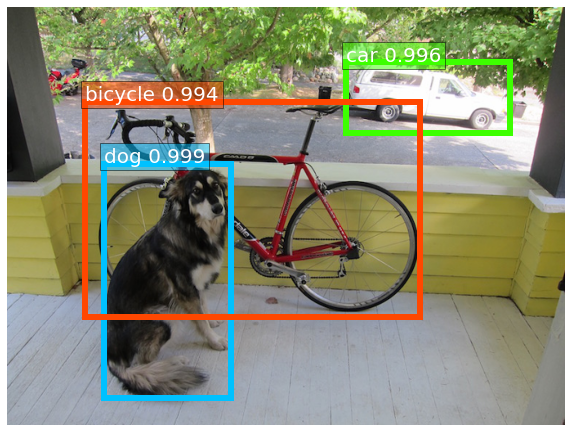

In [16]:
class_IDs, scores, bounding_boxs = net(x)

plt.figure(figsize=(10,10))
utils.viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes, 
                         ax=plt.gca(), linewidth=6, fontsize=20)
plt.axis('off')
plt.show()

### Problem 2: Custom Object Detection with Transfer learning using Yolo-V4

In [1]:
# run in colab
!git clone https://github.com/AlexeyAB/darknet/
%cd darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 13.99 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (10354/10354), done.
/content/darknet


In [ ]:
!apt install libopencv-dev python-opencv ffmpeg

In [ ]:
!pwd
# /content/darknet

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
%cat Makefile

In [ ]:
!make

In [6]:
all_classes = """Raccoon
"""

file = """text_file = open("build/darknet/x64/data/obj.names", "w");text_file.write(all_classes);text_file.close()""" 

exec(file)
%cat build/darknet/x64/data/obj.names

Raccoon


In [7]:
obj_data = """classes= 1
train  = build/darknet/x64/data/train.txt
valid  = build/darknet/x64/data/valid.txt
names = build/darknet/x64/data/obj.names
backup = build/darknet/x64/backup/
"""

file = """text_file = open("build/darknet/x64/data/obj.data", "w");text_file.write(obj_data);text_file.close()""" 

exec(file)
%cat build/darknet/x64/data/obj.data

classes= 1
train  = build/darknet/x64/data/train.txt
valid  = build/darknet/x64/data/valid.txt
names = build/darknet/x64/data/obj.names
backup = build/darknet/x64/backup/


In [ ]:
!wget -P build/darknet/x64/ https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [10]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp -r "/content/drive/MyDrive/racoon/." build/darknet/x64/data/obj/

!pwd
# /content/darknet

#%cd build/darknet/x64/data/obj/
#!ls
#!unzip raccooons.zip
#!mv raccoons/* .
#!rm -rf raccoons
#!rm raccooons.zip
#!ls #-ltr
#%cd '/content/darknet'

In [17]:
%ls -1 build/darknet/x64/data/obj/*.jpg | wc -l
%ls -1 build/darknet/x64/data/obj/*.txt | wc -l

196
196


In [ ]:
import os, fnmatch
import numpy as np

train_file = open("build/darknet/x64/data/train.txt", "w")
valid_file = open("build/darknet/x64/data/valid.txt", "w")
listOfFiles = os.listdir('build/darknet/x64/data/obj/')  
pattern = "*.jpg"  
for f_name in listOfFiles:  
  if fnmatch.fnmatch(f_name, pattern):
    if np.random.rand(1) < 0.8:
      train_file.write("build/darknet/x64/data/obj/"+f_name+"\n")
      #print ("data/obj/"+f_name)
    else:
      valid_file.write("build/darknet/x64/data/obj/"+f_name+"\n")  
      
train_file.close()
valid_file.close()

In [19]:
#Count number of files 
!wc -l build/darknet/x64/data/train.txt
!wc -l build/darknet/x64/data/valid.txt

148 build/darknet/x64/data/train.txt
48 build/darknet/x64/data/valid.txt


In [ ]:
#%cat build/darknet/x64/data/valid.txt

In [ ]:
# !pwd
# /content/darknet

In [ ]:
%cp cfg/yolov4.cfg cfg/yolov4_train.cfg
!sed -i 's/batch=1/batch=64/g' cfg/yolov4_train.cfg
!sed -i 's/subdivisions=1/subdivisions=16/g' cfg/yolov4_train.cfg
!sed -i 's/classes=80/classes=1/g' cfg/yolov4_train.cfg
!sed -i 's/filters=255/filters=18/g' cfg/yolov4_train.cfg
!sed -i 's/max_batches = 500200/max_batches = 2000/g' cfg/yolov4_train.cfg
!sed -i 's/steps=400000,450000/steps=1800,2200/g' cfg/yolov4_train.cfg
#%cat cfg/yolov4_train.cfg

In [ ]:
!./darknet detector train build/darknet/x64/data/obj.data cfg/yolov4_train.cfg build/darknet/x64/yolov4.conv.137 -dont_show

In [ ]:
!./darknet detector test build/darknet/x64/data/obj.data cfg/yolov4_train.cfg build/darknet/x64/backup/yolov4_train_final.weights -dont_show /content/raccoons.jpg

# Predictions
# Raccoon: 79%
# Raccoon: 75%
# Raccoon: 99%

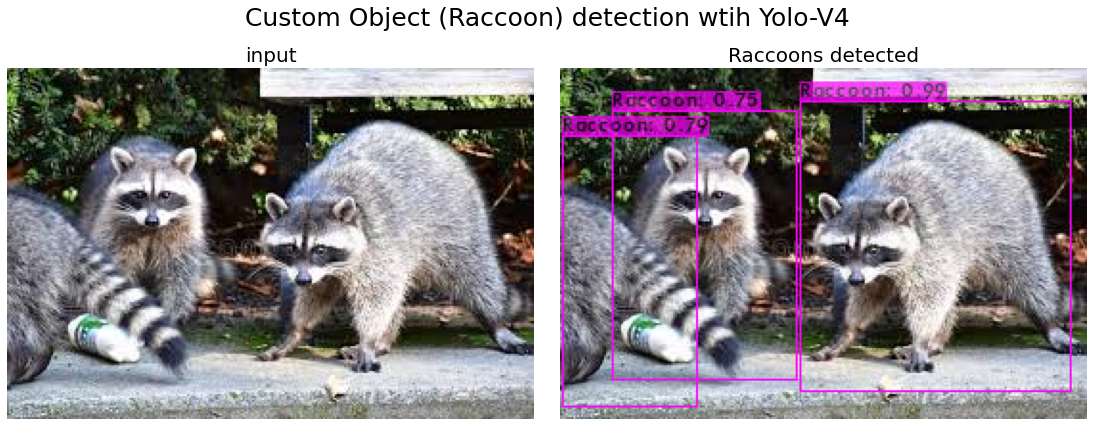

In [16]:
# plot predictions with Yolo-V4

### Problem 3: Selective Coloring with Mask R-CNN

In [4]:
# https://stackoverflow.com/questions/67905185/module-keras-engine-has-no-attribute-layer
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
#from pycocotools.coco import COCO as coco

# Import Mask RCNN
sys.path.append('.')  # To find local version of the library

# Local path to trained weights file
COCO_MODEL_PATH = "models/mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [5]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    #NUM_CLASSES = 37  # COCO has 80 classes
    NUM_CLASSES = 81

class InferenceConfig(CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BATCH_SIZE = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='.', config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [7]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [8]:
len(class_names)

81

In [9]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash

In [10]:
def show_image(image, r, class_names, label='all'):
    if label != 'all':
        class_names = np.array(class_names)
        idx = np.where(class_names[r['class_ids']] != label)
        r['masks'][...,idx] = 0
    mask = np.zeros(image.shape[:2])
    for i in range(r['masks'].shape[2]):
        mask += r['masks'][...,i]
    splash = color_splash(image, r['masks'])
    plt.figure(figsize=(20,10))
    plt.gray()
    plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    plt.subplot(131), plt.imshow(image), plt.axis('off'), plt.title('original image', size=20)
    plt.subplot(132), plt.imshow(mask), plt.axis('off')
    plt.title('mask r-cnn objects{}detected'.format('' if label == 'all' else ' (' + label + ') '), size=20)
    plt.subplot(133), plt.imshow(splash), plt.axis('off'), plt.title('selective coloring of the objects detected', size=20)
    plt.show()

Processing 1 images
image                    shape: (340, 510, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


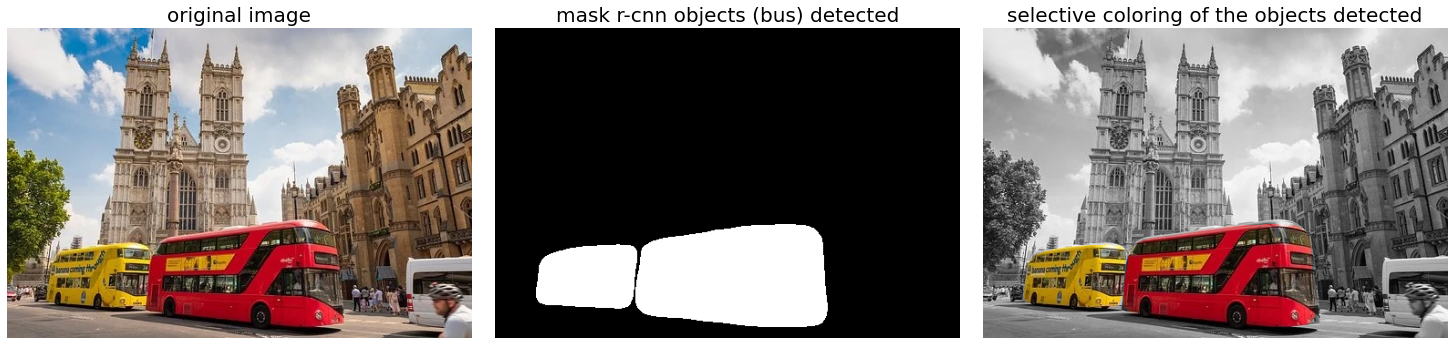

In [11]:
# Load a random image from the images folder
image = skimage.io.imread('images/Img_05_07.jpg')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            class_names, r['scores'])
show_image(image, r, class_names, 'bus')

## Problem 4: Face Verification with DeepFace

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import keras
print(keras.__version__)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
import os

2.0.8


In [35]:
model = Sequential()
model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model.add(Flatten(name='F0'))
model.add(Dense(4096, activation='relu', name='F7'))
model.add(Dropout(rate=0.5, name='D0'))
model.add(Dense(8631, activation='softmax', name='F8'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
model.load_weights("models/VGGFace2_DeepFace_weights_val-0.9034.h5")

In [37]:
deepface_model = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

In [38]:
deepface_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1_input (InputLayer)        (None, 152, 152, 3)       0         
_________________________________________________________________
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
__________

In [39]:
opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]
path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

detector_path = path+"/data/haarcascade_frontalface_default.xml"

if os.path.isfile(detector_path) != True:
    raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")
else:
    detector = cv2.CascadeClassifier(detector_path)
    print("haarcascade is okay")

haarcascade is okay


In [40]:
def detect_face(img_path, target_size=(152, 152)):
    
    img = cv2.imread(img_path)
    #print(img.shape)
    
    faces = detector.detectMultiScale(img, 1.2, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

In [41]:
def find_cosine_distance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def find_euclidean_distance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [252]:
dataset = [
    ['images/spider1.png', 'images/spider2.png', True]
    , ['images/spider3.png', 'images/spider4.png', True]
    
    , ['images/spider1.png', 'images/spider3.png', False]
    , ['images/spider1.png', 'images/spider4.png' , False]
    , ['images/spider2.png', 'images/spider3.png', False]
    , ['images/spider2.png', 'images/spider4.png' , False]
    
    , ['images/spider1.png', 'images/spider5.png' , False]
    , ['images/spider2.png', 'images/spider5.png' , False]
]

In [42]:
def verify_face(dataset, threshold=0.5):
    for case in dataset:
        img1_path = case[0]
        img2_path = case[1]
        target = case[2]

        print(img1_path, " and ", img2_path)

        img1 = detect_face(img1_path)
        img2 = detect_face(img2_path)

        fig = plt.figure()
        fig.add_subplot(1,2, 1)
        plt.imshow(img1[0][:, :, ::-1])
        plt.xticks([]); plt.yticks([])
        fig.add_subplot(1,2, 2)
        plt.imshow(img2[0][:, :, ::-1])
        plt.xticks([]); plt.yticks([])
        plt.show(block=True)

        #img1_embedding = model.predict(img1)[0] #this has 8631 dimensional output
        #img2_embedding = model.predict(img2)[0] #this has 8631 dimensional output
        img1_embedding = deepface_model.predict(img1)[0] #this has 4096 dimensional output
        img2_embedding = deepface_model.predict(img2)[0] #this has 4096 dimensional output

        cosine_distance = find_cosine_distance(img1_embedding, img2_embedding)
        cosine_l2_distance = find_cosine_distance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))
        euclidean_distance = find_euclidean_distance(img1_embedding, img2_embedding)
        euclidean_l2_distance = find_euclidean_distance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))

        #print("Cosine distance: ", cosine_distance)
        #print("Cosine L2 distance: ", cosine_l2_distance)
        #print("Euclidean distance: ", euclidean_distance)
        print("Euclidean L2 distance: ", euclidean_l2_distance)
        print("Actual: ", target, end = '')

        #if cosine_distance < 0.16:
        if euclidean_l2_distance <= threshold:
            verified = True
        else:
            verified = False

        print(" - Predicted: ", verified)

        print("----------------------------------------------")

images/spider1.png  and  images/spider2.png


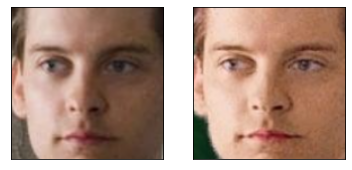

Euclidean L2 distance:  0.26329562
Actual:  True - Predicted:  True
----------------------------------------------
images/spider3.png  and  images/spider4.png


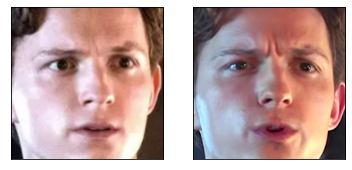

Euclidean L2 distance:  0.44354624
Actual:  True - Predicted:  True
----------------------------------------------
images/spider1.png  and  images/spider3.png


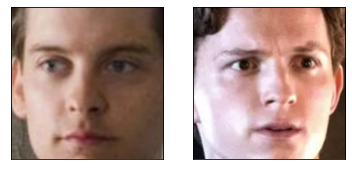

Euclidean L2 distance:  0.738246
Actual:  False - Predicted:  False
----------------------------------------------
images/spider1.png  and  images/spider4.png


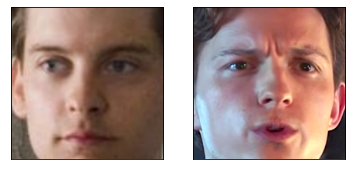

Euclidean L2 distance:  0.76820296
Actual:  False - Predicted:  False
----------------------------------------------
images/spider2.png  and  images/spider3.png


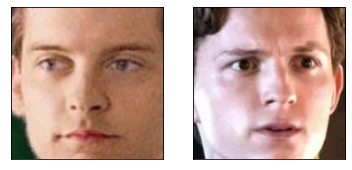

Euclidean L2 distance:  0.7440376
Actual:  False - Predicted:  False
----------------------------------------------
images/spider2.png  and  images/spider4.png


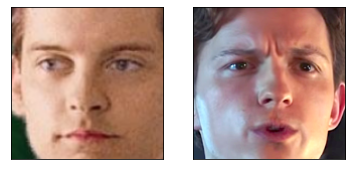

Euclidean L2 distance:  0.7582312
Actual:  False - Predicted:  False
----------------------------------------------
images/spider1.png  and  images/spider5.png


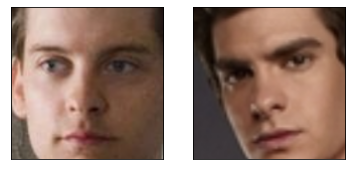

Euclidean L2 distance:  0.82433444
Actual:  False - Predicted:  False
----------------------------------------------
images/spider2.png  and  images/spider5.png


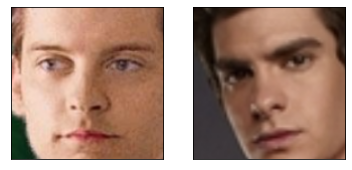

Euclidean L2 distance:  0.82494193
Actual:  False - Predicted:  False
----------------------------------------------


In [256]:
verify_face(dataset)

In [43]:
dataset = [
    ['images/mom1.png', 'images/mom2.png', True]
    , ['images/dad1.png', 'images/dad2.png', True]
    
    , ['images/mom1.png', 'images/dad1.png', False]
    , ['images/mom1.png', 'images/dad2.png' , False]
    , ['images/mom2.png', 'images/dad1.png', False]
    , ['images/mom2.png', 'images/dad2.png' , False]
    
    , ['images/mom1.png', 'images/me.png' , False]
    , ['images/dad1.png', 'images/me.png' , False]
]

images/mom1.png  and  images/mom2.png


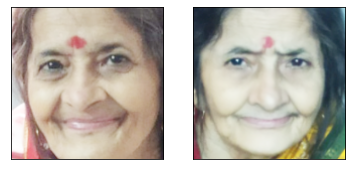

Euclidean L2 distance:  0.613981
Actual:  True - Predicted:  True
----------------------------------------------
images/dad1.png  and  images/dad2.png


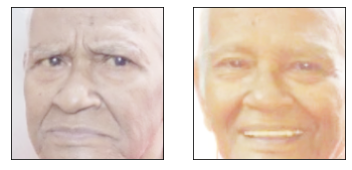

Euclidean L2 distance:  0.6548084
Actual:  True - Predicted:  True
----------------------------------------------
images/mom1.png  and  images/dad1.png


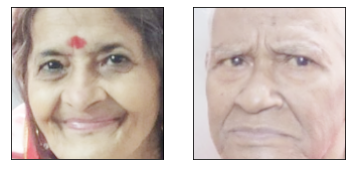

Euclidean L2 distance:  0.7342185
Actual:  False - Predicted:  False
----------------------------------------------
images/mom1.png  and  images/dad2.png


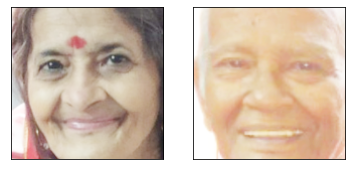

Euclidean L2 distance:  0.6903178
Actual:  False - Predicted:  False
----------------------------------------------
images/mom2.png  and  images/dad1.png


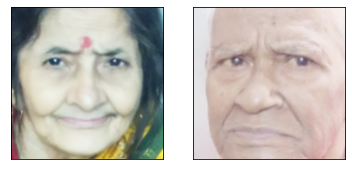

Euclidean L2 distance:  0.77947927
Actual:  False - Predicted:  False
----------------------------------------------
images/mom2.png  and  images/dad2.png


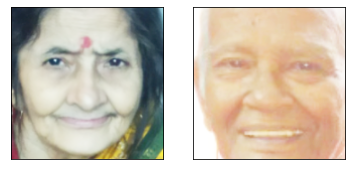

Euclidean L2 distance:  0.75074714
Actual:  False - Predicted:  False
----------------------------------------------
images/mom1.png  and  images/me.png


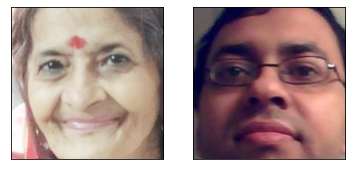

Euclidean L2 distance:  0.8190964
Actual:  False - Predicted:  False
----------------------------------------------
images/dad1.png  and  images/me.png


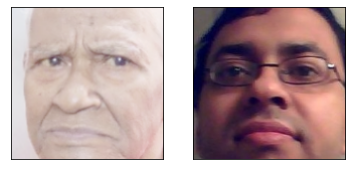

Euclidean L2 distance:  0.8458995
Actual:  False - Predicted:  False
----------------------------------------------


In [44]:
verify_face(dataset, 0.66)

## Problem 5: Barcode Detection

In [2]:
#! pip install python-Levenshtein
#! pip install python-barcode
#! pip install qrcode
#! pip install pyzbar
from PIL import ImageFont, ImageDraw, Image  
from pyzbar import pyzbar
import cv2
import numpy as np
import barcode
import qrcode
from barcode.writer import ImageWriter
import matplotlib.pylab as plt

In [8]:
bar1 = barcode.get('ean13', str('123456789012'), writer=ImageWriter())
#bar1 = barcode.codex.Code39( "Sandipan Dey - Image Processing - Packt",  writer=ImageWriter(),  add_checksum=False)
bar1.save('images/bar1')

qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(u'বই: Image Processing MasterClass (BPB)')
qr.make(fit=True)
bar2 = qr.make_image(fill_color="black", back_color="white")
bar2.save('images/bar2.png')

im_orig = Image.open('images/book_cover.png')
#print(im_orig.size)
im = im_orig.copy()
bar1 = Image.open('images/bar1.png')
bar2 = Image.open('images/bar2.png')
im.paste(bar1.resize((262,140)).rotate(10), (550,10,812,150))
im.paste(bar2.resize((100,100)).rotate(-10), (400,860,500,960))
im.save('images/book_cover_barcode.png')

In [43]:
# load the input image
im_bar = cv2.imread('images/book_cover_barcode.png')
cv2_im_rgb = cv2.cvtColor(im_bar, cv2.COLOR_BGR2RGB)  
pil_im = Image.fromarray(cv2_im_rgb)  
# find the barcodes in the image and decode each of the barcodes
barcodes = pyzbar.decode(im_bar)
print(len(barcodes))
# loop over the detected barcodes
for barcode in barcodes:
    # extract the bounding box location of the barcode and draw the
    # bounding box surrounding the barcode on the image
    (x, y, w, h) = barcode.rect
    
    # the barcode data is a bytes object so if we want to draw it on
    # our output image we need to convert it to a string first
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
    
    #if barcodeType == 'EAN13':
    #    barcodeData = bytes.fromhex('0'+ hex(int(barcodeData))[2:]).decode("utf-8")
 
    # draw the barcode data and barcode type on the image
    text = u"{} ({})".format(barcodeData, barcodeType)
    
    # Convert the image to RGB (OpenCV uses BGR)  
    draw = ImageDraw.Draw(pil_im)  
    font = ImageFont.truetype("images/kalpurush.ttf", size=40, layout_engine=ImageFont.LAYOUT_RAQM)  
    draw.line(barcode.polygon,width=15)
    draw.polygon(barcode.polygon, outline='#0000ff')
    draw.rectangle(((x, y), (x + w, y + h)), outline='#ff0000', width=10)
    draw.text((x - 120, y + h + 1), text, font=font, fill=(255,0,0,255), stroke_width=2)  
    
    # print the barcode type and data to the terminal
    print("[INFO] Found {} barcode: {}".format(barcodeType, barcodeData))
    
im_out = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)  
cv2.imwrite('images/book_cover_barcode_detected.png', im_out)    

2
[INFO] Found QRCODE barcode: বই: Image Processing MasterClass (BPB)
[INFO] Found EAN13 barcode: 1234567890128


True

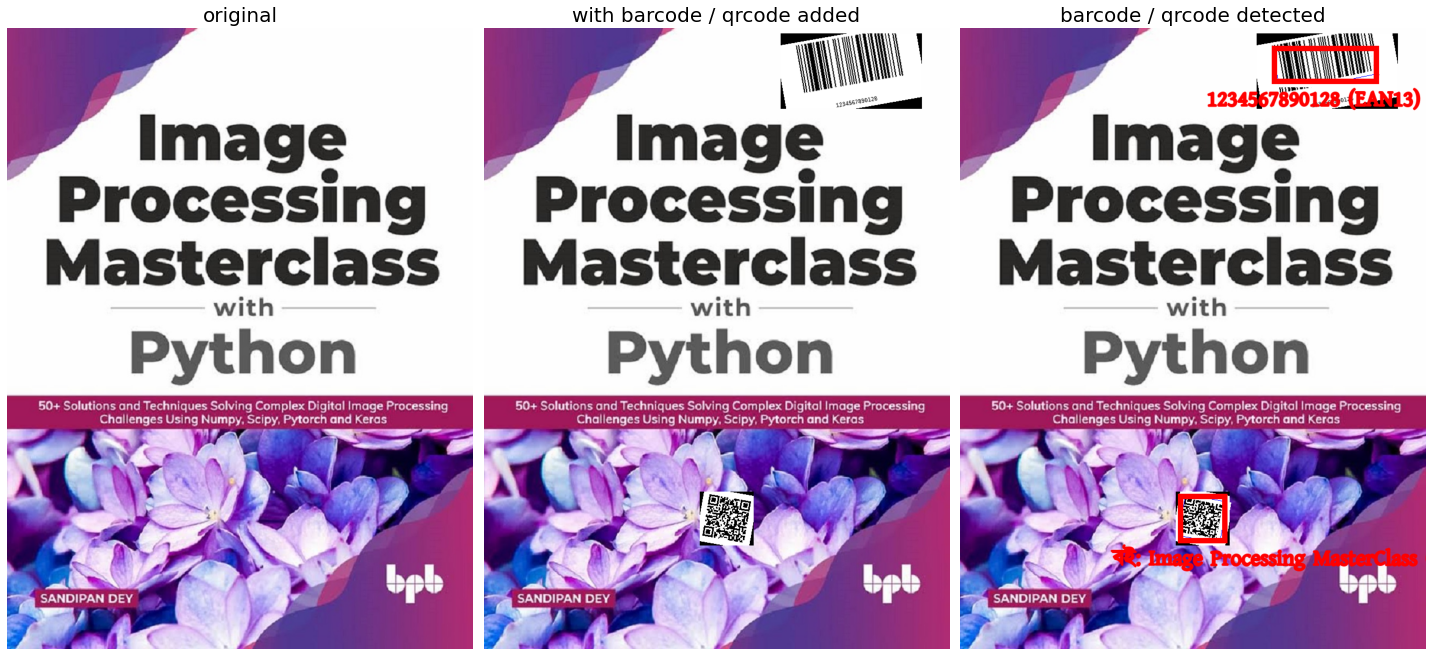

In [44]:
plt.figure(figsize=(20,10))
plt.subplot(131), plt.imshow(im_orig), plt.title('original', size=20), plt.axis('off')
plt.subplot(132), plt.imshow(cv2.cvtColor(im_bar, cv2.COLOR_BGR2RGB)), plt.title('with barcode / qrcode added', size=20), plt.axis('off')
plt.subplot(133), plt.imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB)), plt.title('barcode / qrcode detected', size=20), plt.axis('off')
plt.tight_layout()
plt.show()

## Questions

1. **Face Recognition** with `keras_vggface`: Bbuild a simple face recognition system using the Keras VGGFace model. You need to load a pretrained VGGFace model, process an input image of a celebrity, and use the function `decode_predictions()` to identify the face.

    **Hint**: Here are the key steps:
        - Install and import required libraries, e.g, `keras_vggface`, `keras_applications` etc.
        - Load the **VGGFace** model using `VGGFace(model='vgg16', include_top=True)`.
        - Preprocess an input face image, resize it to $224\times 224$, convert it to a `numpy` array, expand dimensions, and preprocess using `keras_vggface.utils.preprocess_input()`.
        - Predict the face identity by passing the image through the model and use `decode_predictions()` to get the top predicted identities.
        - Display the image and the predicted name(s), e.g., print the top $5$ predictions with their confidence scores.
    
    For example, with SRK face image as input, first crop the image and predict the celebrity name to obtain the output as shown below:
    
    ![](images/fcr.png)
    
    Now, you may want to think on the following questions:
    - What is the size and format of the input expected by **VGGFace**?
    - How does `decode_predictions()` help interpret the model output?
    - Try using a different celebrity face—does the prediction change as expected?
    - Use multiple test images and compare the model's recognition confidence. What happens with low-resolution or occluded faces?

      
2. Explore the following **online annotation tools**:

    a.	labelImg (https://github.com/HumanSignal/labelImg )
    b.	VIA (https://www.robots.ox.ac.uk/~vgg/software/via/ )
    c.	labelme (http://labelme.csail.mit.edu/Release3.0/ )
    d.	imagetagger (https://github.com/bit-bots/imagetagger ) 

   Learn how to use them to manually annotate images and extract the bounding boxes corresponding to the custom objects you want to detect with YoloV4 darknet model, and prepare the training dataset (make sure that the annotation text format is same as the model accepts). Also, use roboflow (https://app.roboflow.com/ ) to automatically/semi-automatically annotate custom images (for example, try the raccoon), as shown in the following figure:

    ![](images/robo.png)

   
4. For the following raccoon image and the given annotation text corresponding to the bounding box for the object (for **YOLOv4 DarkNet** model), write code to draw bounding box. For the given input image you should obtain the annotated output image shown side-by-side.

    ![](images/annot_out.png)

6. **Intersection over Union (IoU)**: IoU is a widely used metric for assessing the performance of an object detection model. It measures how well the predicted bounding box (by the model) matches the ground truth (true) bounding box. IoU is calculated as the ratio of the intersection area between the predicted and ground truth bounding boxes to the total area covered by both boxes. The formula to compute IoU is as follows:
                        $$IoU=\frac{AreaofOverlap}{AreaofUnion}$$
    where, we have
	- **Area of Overlap**: The region where the predicted bounding box intersects with the ground truth bounding box.
	- **Area of Union**: The sum  of  the area covered by both the bounding boxes combined.

    In object detection, the IoU helps in determining the correctness of a detected object.
	- **High IoU (close to 1)**: The prediction is very close to the ground truth.
	- **Low IoU (close to 0)**: The prediction is far from the ground truth.
	- **Thresholding**: Typically, An IoU threshold (such as 0.5) is commonly used to determine whether a detection is classified as a True Positive (TP) or a False Positive (FP). When the IoU of a predicted bounding box and a ground truth box is above the threshold, it is considered a True Positive. If it is below the threshold, it is a False Positive.
	- **IoU** is used to compute evaluation metrics like Precision, Recall, and the mean Average Precision (mAP), which are commonly used tomeasure the performance of the models.

    Now, your exercise is to complete the implementation of the following function `compute_iou()` which accepts two bounding boxes as arguments and returns the IOU of these two bboxes computed.

In [ ]:
def compute_iou(box1, box2):
    """
    Computes Intersection over Union (IoU) between box1 & box2.    
    Arguments:
    box1, box2 -- List or tuple containing coordinates of the 
    bounding boxes in the format: (x_min, y_min, x_max, y_max)    
    Returns:
    iou -- Intersection over Union (IoU) value
    """
    iou = None

    ### ***Your Code Here*** ###
    
    return iou

# Example usage
box1 = [50, 50, 150, 150]  # Ground truth bounding box
box2 = [100, 100, 200, 200]  # Predicted bounding box

# test your implementation
iou_value = compute_iou(box1, box2)
# print(f"IoU: {iou_value}") # uncomment to print
# IoU: 0.14285714285714285  # you should obtain this IOU value

5. **Car License Plate Detection with YOLOv5 and Tesseract OCR**: Implement a complete pipeline for car license plate detection and recognition using pretrained (fine-tuned) **YOLOv5** model and **Tesseract OCR** (an open-source optical character recognition engine that extracts text from images by detecting character shapes using a neural network-based recognition pipeline). Here is a step-by-step guide for your implementation: 

- **Download Dataset**: Use the Car Plate Detection dataset from **Kaggle**: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection (with annotations in the **PASCAL VOC** format)
- **Set Up YOLOv5**:
  - Clone YOLOv5: `!git clone https://github.com/ultralytics/yolov5`
  - Install requirements: `!pip install -r yolov5/requirements.txt`
- **Prepare the Dataset**:
    - Convert XML annotations to **YOLO** format (.txt files).
    - Split into `training` and `validation` sets.
    - Create a `data.yaml` file with $1$ class: ['licence'].
- **Train** **YOLOv5** using **Transfer Learning**:
  - Download a pretrained checkpoint (e.g., `yolov5m6.pt`) from: https://github.com/ultralytics/yolov5/releases
  - Fine-tune it on your dataset: `!python train.py --img 1280 --batch 4 --epochs 20 --data bgr.yaml --weights yolov5m6.pt`
- **Detect License Plates**: Run inference on test images using your fine-tuned model: `!python detect.py --source /path/to/image --weights best.pt`

- **Apply OCR using Tesseract**
  - Install OCR tools: `!sudo apt install tesseract-ocr`, `!pip install pytesseract`
  - Crop detected plate regions and extract text: use the function `pytesseract.image_to_string()`

- Display the final image showing detected plates and recognized text. you should obtain a figure like the one below:

![](images/license_out.png)

### References

1. https://www.youtube.com/watch?v=CgLp7cW5QJU
2. https://www.youtube.com/watch?v=Wq_vAWQ0Y_w
3. https://www.youtube.com/watch?v=xr_wpaGxlTk
4. https://www.youtube.com/watch?v=w5nHj1e5nfI
5. https://www.youtube.com/watch?v=2xNXWy7ubKs